# Flux calibration

Photometric and spectroscopic measurements of directly imaged planets typically provide the flux contrast between the companion and star. To calibrate the contrast of the companion to a flux or apparent magnitude requires an absolute measurement of the stellar flux.

In this tutorial, we will we will fit the [Gaia DR3](https://www.cosmos.esa.int/web/gaia/home) and [2MASS](https://irsa.ipac.caltech.edu/Missions/2mass.html) magnitudes of the G7 type star [PZ Tel](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=PZ+Tel) with the [BT-NextGen](http://svo2.cab.inta-csic.es/svo/theory/newov2/index.php?models=bt-nextgen-agss2009) model spectra. From the posterior samples, we will then compute synthetic photometry for the [VLT/ERIS M' filter](http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?id=Paranal/ERIS.Mp&&mode=browse&gname=Paranal&gname2=ERIS#filter) and a synthetic spectrum for a given instrument resolution and wavelength binning.

## Getting started

We start by importing the required Python modules.

In [1]:
import calistar
import numpy as np
import species

Next, we initiate the workflow by calling the [SpeciesInit](https://species.readthedocs.io/en/latest/species.core.html#species.core.init.SpeciesInit) class. This will create both the [HDF5 database](https://species.readthedocs.io/en/latest/database.html) and the [configuration file](https://species.readthedocs.io/en/latest/configuration.html) in the working folder.

In [2]:
species.SpeciesInit()

species v0.7.4
Working folder: /Users/tomasstolker/applications/species/docs/tutorials
Creating species_config.ini... [DONE]
Configuration settings:
   - Database: /Users/tomasstolker/applications/species/docs/tutorials/species_database.hdf5
   - Data folder: /Users/tomasstolker/applications/species/docs/tutorials/data
   - Interpolation method: linear
   - Magnitude of Vega: 0.03
Creating species_database.hdf5... [DONE]
Creating data folder... [DONE]


We then create an instance of [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database), which provides read and write access to the HDF5 database.

In [3]:
database = species.Database()

We will use the [calistar](https://calistar.readthedocs.io) tool to retrieve the Gaia DR3 parallax of [PZ Tel](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=PZ+Tel) and the Gaia, 2MASS, and WISE magnitudes. Similar to `species`, the `calistar` tool uses also the filter names as defined by the [SVO Filter Profile Service](http://svo2.cab.inta-csic.es/svo/theory/fps/). We start by creating an instance of the [CaliStar](https://calistar.readthedocs.io/en/latest/calistar.html#calistar.calistar.CaliStar) class for which we provide the Gaia DR3 source ID of PZ Tel as input (see [Simbad](https://simbad.u-strasbg.fr/simbad/sim-basic?Ident=pz+tel)).

In [4]:
cal_star = calistar.CaliStar(gaia_source=6655168686921108864, gaia_release='DR3')

calistar v0.0.1

Next, we run the [target_star](https://calistar.readthedocs.io/en/latest/calistar.html#calistar.calistar.CaliStar.target_star) to retrieve the astrometric and photometric properties of PZ Tel, which are returned in a dictionary.

In [5]:
target_dict = cal_star.target_star(write_json=False)


-> Querying GAIA DR3...

INFO: Query finished. [astroquery.utils.tap.core]

GAIA DR3 source ID = 6655168686921108864
Reference epoch = 2016.0
Parallax = 21.16 +/- 0.02 mas

RA = 283.274586 deg +/- 0.0162 mas
Dec = -50.180907 deg +/- 0.0174 mas
Coordinates = +18h53m05.90s -50d10m51.27s

Proper motion RA = 16.27 +/- 0.02 mas/yr
Proper motion Dec = -85.52 +/- 0.02 mas/yr
Radial velocity = -3.59 +/- 1.55 km/s

G mag = 8.101660 +/- 0.003166
BP mag = 8.496099 +/- 0.005965
RP mag = 7.526747 +/- 0.005561
GRVS mag = 7.288631 +/- 0.009597

Effective temperature = 5214 K
Surface gravity = 4.25
Metallicity = -0.82
G-band extinction = 0.00

Non single star = False
Single star probability from DSC-Combmod = 1.00
Astrometric excess noise = 0.11

XP continuous = True
XP sampled = True
RVS spectrum = False

-> Querying Simbad...

Simbad ID = V* PZ Tel
Spectral type = G9IV

2MASS J mag = 6.856 +/- 0.021
2MASS H mag = 6.486 +/- 0.049
2MASS Ks mag = 6.366 +/- 0.024

-> Querying VizieR...

ALLWISE source 

We will then assign the parralax to a separate variable and write the magnitudes to a new dictionary.

In [6]:
parallax = target_dict['Gaia parallax']

In [7]:
magnitudes = {'GAIA/GAIA3.G': target_dict['GAIA/GAIA3.G'],
              'GAIA/GAIA3.Gbp': target_dict['GAIA/GAIA3.Gbp'],
              'GAIA/GAIA3.Grp': target_dict['GAIA/GAIA3.Grp'],
              'GAIA/GAIA3.Grvs': target_dict['GAIA/GAIA3.Grvs'],
              '2MASS/2MASS.J': target_dict['2MASS/2MASS.J'],
              '2MASS/2MASS.H': target_dict['2MASS/2MASS.H'],
              '2MASS/2MASS.Ks': target_dict['2MASS/2MASS.Ks']}

We also create a list of the filter names for use later on.

In [8]:
filters = list(magnitudes.keys())

## Adding stellar photometry

We can now store the parallax and magnitudes of PZ Tel in the database by using the [add_object](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.add_object) method. This will also download a flux-calibrated spectrum of Vega and convert the magnitudes into fluxes.

In [9]:
database.add_object(object_name='PZ Tel',
                    parallax=parallax,
                    app_mag=magnitudes,
                    spectrum=None)

Adding filter: GAIA/GAIA3.G... [DONE]
Adding filter: GAIA/GAIA3.Gbp... [DONE]
Adding filter: GAIA/GAIA3.Grp... [DONE]
Adding filter: GAIA/GAIA3.Grvs... [DONE]
Adding filter: 2MASS/2MASS.J... [DONE]
Adding filter: 2MASS/2MASS.H... [DONE]
Adding filter: 2MASS/2MASS.Ks...

 [DONE]


100%|████████████████████████████████████████| 288k/288k [00:00<00:00, 170MB/s]

Adding Vega spectrum... [DONE]
Reference: Bohlin et al. 2014, PASP, 126
URL: https://ui.adsabs.harvard.edu/abs/2014PASP..126..711B/abstract
Adding object: PZ Tel
   - Parallax (mas) = 21.16 +/- 0.02
   - GAIA/GAIA3.G:
      - Mean wavelength (um) = 2.1656e+00
      - Apparent magnitude = 8.10 +/- 0.00
      - Flux (W m-2 um-1) = 1.48e-11 +/- 4.32e-14
   - GAIA/GAIA3.Gbp:
      - Mean wavelength (um) = 2.1656e+00
      - Apparent magnitude = 8.50 +/- 0.01
      - Flux (W m-2 um-1) = 1.68e-11 +/- 9.21e-14
   - GAIA/GAIA3.Grp:
      - Mean wavelength (um) = 2.1656e+00
      - Apparent magnitude = 7.53 +/- 0.01
      - Flux (W m-2 um-1) = 1.27e-11 +/- 6.52e-14
   - GAIA/GAIA3.Grvs:
      - Mean wavelength (um) = 2.1656e+00
      - Apparent magnitude = 7.29 +/- 0.01
      - Flux (W m-2 um-1) = 1.13e-11 +/- 9.97e-14
   - 2MASS/2MASS.J:
      - Mean wavelength (um) = 2.1656e+00
      - Apparent magnitude = 6.86 +/- 0.02
      - Flux (W m-2 um-1) = 5.74e-12 +/- 1.11e-13
   - 2MASS/2MASS.H:
   

## Adding a grid of model spectra

Next, we will download the *BT-NextGen* grid and add the spectra of a specified $T_\mathrm{eff}$ range to the database.

In [10]:
database.add_model('bt-nextgen', teff_range=(3000., 8000.))

100%|████████████████████████████████████████| 385M/385M [00:00<00:00, 141GB/s]
SHA256 hash of downloaded file: d07093865a3632a45d8463c30fb885bca94d00cb40c524d433165175a2c49c6a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


Unpacking BT-NextGen model spectra (368 MB)... [DONE]
Wavelength range (um) = 0.1 - 50
Spectral resolution = 4000
Teff range (K) = 3000.0 - 8000.0
Adding BT-NextGen model spectra... [DONE]                                        
Grid points stored in the database:
   - Teff = [3000. 3100. 3200. 3300. 3400. 3500. 3600. 3700. 3800. 3900. 4000. 4100.
 4200. 4300. 4400. 4500. 4600. 4700. 4800. 4900. 5000. 5100. 5200. 5300.
 5400. 5500. 5600. 5700. 5800. 5900. 6000. 6100. 6200. 6300. 6400. 6500.
 6600. 6700. 6800. 6900. 7000. 7200. 7400. 7600. 7800. 8000.]
   - log(g) = [3. 4. 5.]
   - [Fe/H] = [0.  0.3 0.5]
Number of grid points per parameter:
   - teff: 46
   - logg: 3
   - feh: 3
Fix missing grid points with a linear interpolation:
Number of stored grid points: 414
Number of interpolated grid points: 0
Number of missing grid points: 0


## Fitting the 2MASS fluxes with the calibration spectrum

Now that we have prepared the database, we can fit the photometric fluxes with the model grid. To do so, we use the [FitModel](https://species.readthedocs.io/en/latest/species.analysis.html#species.analysis.fit_model.FitModel) class, which provides a Bayesian framework for parameter estimation. The argument of `bounds` contains a dictionary with the priors that are used. In this example, we fix $T_\mathrm{eff}$, $\log(g)$, and $[\mathrm{Fe}/\mathrm{H}]$, so we effectively scale the model spectrum to the data by adjusting the distance and radius. We will also account for a instrument-specific error inflation, relative to the actual uncertainties on the 2MASS fluxes (so allowing them to increase up to a factor of 10). Finally, the parallax is automatically included with a Gaussian prior.

In [11]:
fit = species.FitModel(object_name='PZ Tel',
                       model='bt-nextgen',
                       bounds={'teff': None,
                               'logg': None,
                               'feh': (0., 0.),
                               'radius': (1., 20.),
                               'GAIA/GAIA3_error': (1., 20.),
                               '2MASS/2MASS_error': (1., 10.)},
                       inc_phot=True,
                       inc_spec=False)

Getting object: PZ Tel... [DONE]
Interpolating 2MASS/2MASS.H... [DONE]
Interpolating 2MASS/2MASS.J... [DONE]
Interpolating 2MASS/2MASS.Ks... [DONE]
Interpolating GAIA/GAIA3.G... [DONE]
Interpolating GAIA/GAIA3.Gbp... [DONE]
Interpolating GAIA/GAIA3.Grp... [DONE]
Interpolating GAIA/GAIA3.Grvs... [DONE]
Fixing 1 parameters:
   - feh = 0.0
Fitting 6 parameters:
   - teff
   - logg
   - radius
   - parallax
   - 2MASS/2MASS_error
   - GAIA/GAIA3_error
Prior boundaries:
   - teff = (3000.0, 8000.0)
   - logg = (3.0, 5.0)
   - radius = (1.0, 20.0)
   - GAIA/GAIA3_error = (1.0, 20.0)
   - 2MASS/2MASS_error = (1.0, 10.0)
Weights for the log-likelihood function:
   - 2MASS/2MASS.H = 1.00
   - 2MASS/2MASS.J = 1.00
   - 2MASS/2MASS.Ks = 1.00
   - GAIA/GAIA3.G = 1.00
   - GAIA/GAIA3.Gbp = 1.00
   - GAIA/GAIA3.Grp = 1.00
   - GAIA/GAIA3.Grvs = 1.00


We will sample the posterior distribution with the [run_ultranest](https://species.readthedocs.io/en/latest/species.analysis.html#species.analysis.fit_model.FitModel.run_ultranest), which uses the nested sampling implementation of [UltraNest](https://johannesbuchner.github.io/UltraNest/index.html). The samples will be stored in the database by the `tag` name. Let's run the sampler with 500 live points!

In [12]:
fit.run_ultranest(tag='pztel',
                  min_num_live_points=500,
                  output='ultranest/',
                  prior=None)

Running nested sampling with UltraNest...
Creating directory for new run ultranest/run1
[ultranest] Sampling 500 live points from prior ...
[ultranest] Explored until L=2e+02  9 [197.9147..197.9163]*| it/evals=8786/44473 eff=19.9804% N=500  =500 0 
[ultranest] Likelihood function evaluations: 44533
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = 185.2 +- 0.1172
[ultranest] Effective samples strategy satisfied (ESS = 4353.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.13 bs:0.12 tail:0.01 total:0.12 required:<0.50
[ultranest] done iterating.
Log-evidence = 185.14 +/- 0.27
Best-fit parameters (mean +/- std):
   - teff = 5.31e+03 +/- 6.75e+01
   - logg = 3.87e+00 +/- 5.67e-01
   - radius = 1.17e+01 +/- 3.28e-01
   - parallax = 2.

/Users/tomasstolker/.pyenv/versions/3.11.5/envs/species3.11/lib/python3.11/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]


## Plotting the posterior distribution

After running the sampler, we can plot the posterior distribution of the 3 free parameters with the [plot_posterior](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_mcmc.plot_posterior) by simply pointing to the database `tag` that was specified with [run_ultranest](https://species.readthedocs.io/en/latest/species.analysis.html#species.analysis.fit_model.FitModel.run_ultranest).

Median sample:
   - teff = 5.30e+03
   - logg = 3.82e+00
   - radius = 1.17e+01
   - parallax = 2.12e+01
   - 2MASS/2MASS_error = 2.16e+00
   - GAIA/GAIA3_error = 4.68e+00
   - feh = 0.00e+00
Maximum posterior sample:
   - teff = 5.32e+03
   - logg = 4.72e+00
   - radius = 1.16e+01
   - parallax = 2.12e+01
   - 2MASS/2MASS_error = 1.41e+00
   - GAIA/GAIA3_error = 2.49e+00
   - feh = 0.00e+00
Plotting the posterior...

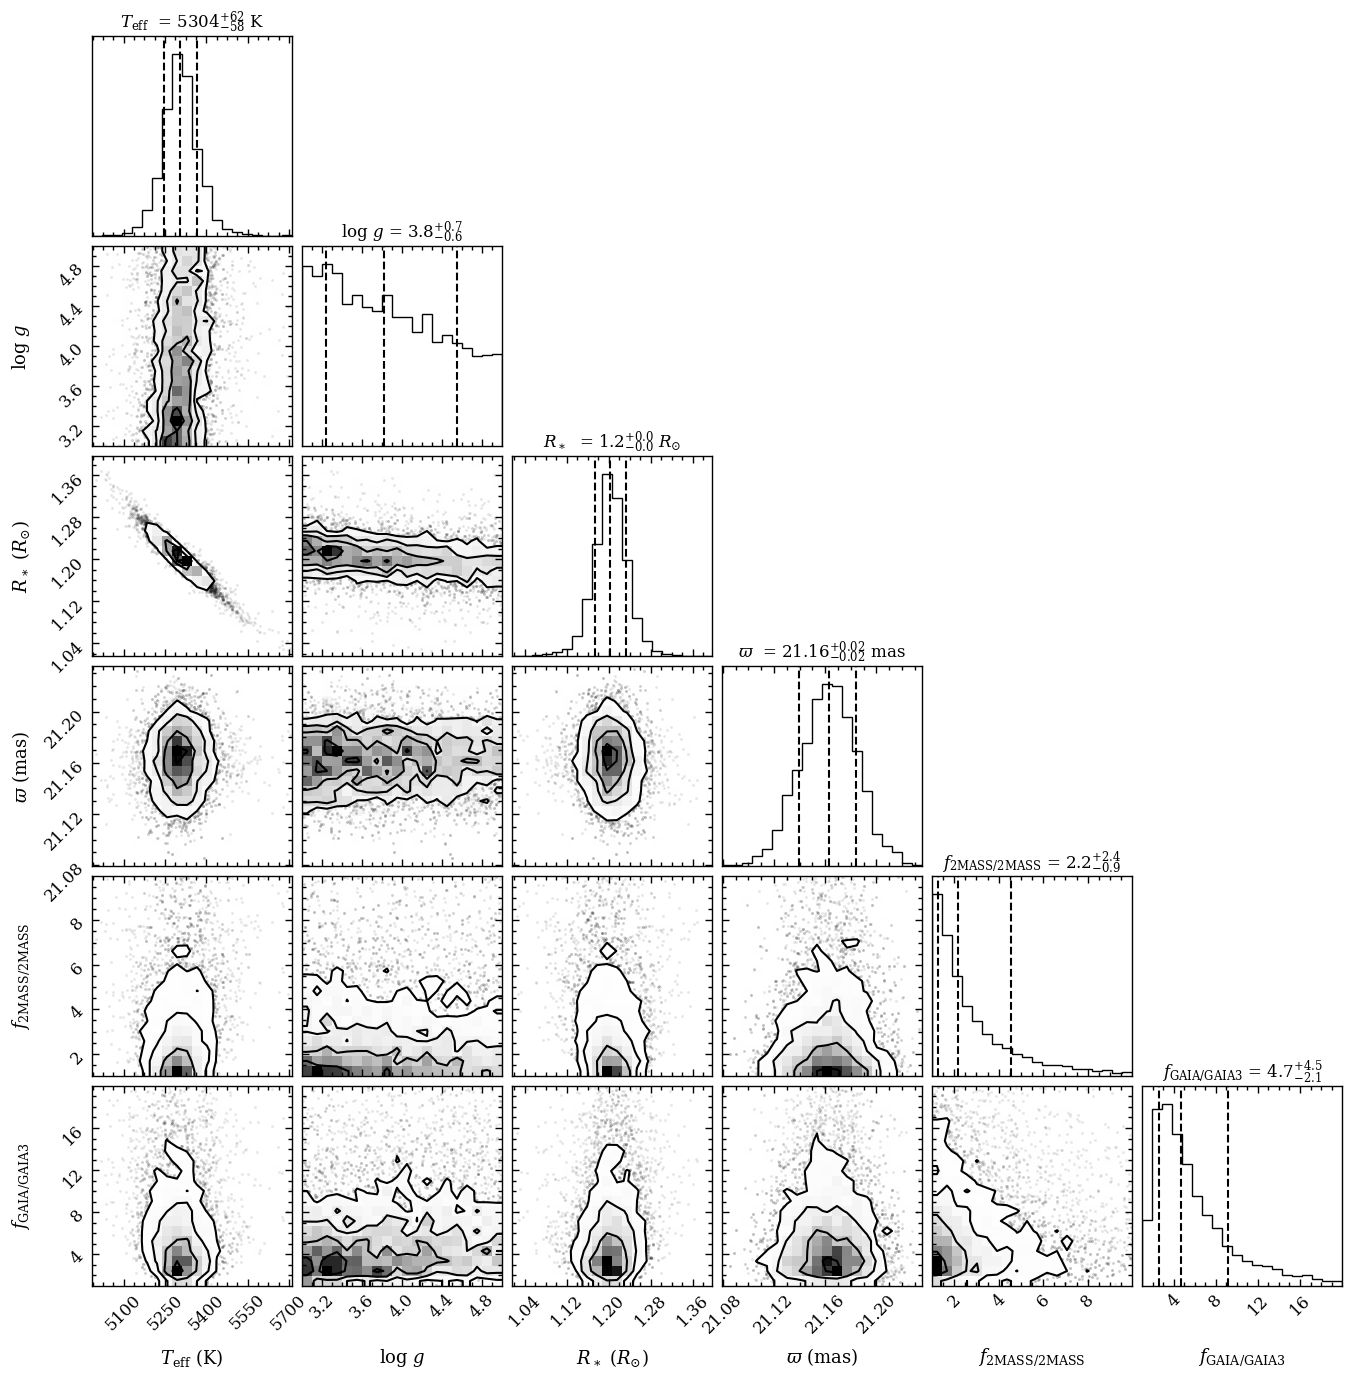

 [DONE]


In [13]:
fig = species.plot_posterior(tag='pztel',
                             offset=(-0.3, -0.3),
                             title_fmt=['.0f', '.1f', '.1f', '.2f', '.1f', '.1f'],
                             object_type='star',
                             output=None)

The corner plot shows that the surface gravity, $\log{(g)}$, is unconstrained. That is to be expected when fitting only photometric fluxes. The [plot_posterior](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_mcmc.plot_posterior) function returned the [Figure](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) object of the plot. The functionalities of [Matplotlib](https://matplotlib.org/stable/index.html) can be used for further customization of the plot. For example, the axes of the plot are stored at the `axes` attribute of `Figure`.

## Extracting spectral samples

Later on, we will create a plot of the data, best-fit spectrum, and random spectral samples of the posterior distribution. We start by drawing 30 random samples the posterior distribution and calculate spectra at $R = 100$. The [get_mcmc_spectra](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_mcmc_spectra) method of [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database) returns a list with [ModelBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ModelBox) objects.

In [14]:
samples = database.get_mcmc_spectra(tag='pztel',
                                    random=30,
                                    wavel_range=(0.2, 10.),
                                    spec_res=100.)

Getting MCMC spectra:   0%|          | 0/30 [00:00<?, ?it/s]

/Users/tomasstolker/applications/species/species/read/read_model.py:799: UserWarning: The '2MASS/2MASS_error' parameter is not required by 'bt-nextgen' so the parameter will be ignored. The mandatory parameters are ['teff', 'logg', 'feh'].
  warnings.warn(
/Users/tomasstolker/applications/species/species/read/read_model.py:799: UserWarning: The 'GAIA/GAIA3_error' parameter is not required by 'bt-nextgen' so the parameter will be ignored. The mandatory parameters are ['teff', 'logg', 'feh'].
  warnings.warn(


Let's have a look at the content of the first [ModelBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ModelBox) by using the [open_box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box.open_box) method.

In [15]:
samples[0].open_box()

Opening ModelBox...
model = bt-nextgen
type = None
wavelength = [ 0.19996262  0.20001213  0.20006165 ...  9.99710369  9.99957902
 10.00205496]
flux = [5.22517899e-15 5.25394049e-15 5.28270531e-15 ... 3.51496978e-15
 3.51321670e-15 3.51154092e-15]
parameters = {'teff': 5217.864989644976, 'logg': 3.8675466417798106, 'radius': 11.994925646935222, 'parallax': 21.184547812933125, '2MASS/2MASS_error': 1.7974102132257372, 'GAIA/GAIA3_error': 6.476770269043802, 'feh': 0.0, 'luminosity': 1.0146845232410795, 'mass': 427.8841653139212}
quantity = flux
contribution = None
bol_flux = None


Next, we extract the best-fit parameters from the posterior distribution, for which we adopt the sample with the highest likelihood value. The [get_probable_sample](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_probable_sample) function returns a dictionary with the parameters, including the ones that were fixed with [FitModel](https://species.readthedocs.io/en/latest/species.analysis.html#species.analysis.fit_model.FitModel).

In [16]:
best_sample = database.get_probable_sample(tag='pztel')
print(best_sample)

{'teff': 5317.928993215377, 'logg': 4.721265482960822, 'radius': 11.594760705181677, 'parallax': 21.19025976666689, '2MASS/2MASS_error': 1.4130887127830687, 'GAIA/GAIA3_error': 2.4857905838845387, 'feh': 0.0}


Next, we interpolate the the *BT-NextGen* grid at the best-fit parameters. To do so, we first create an instance of [ReadModel](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel) and then use the [get_model](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel.get_model) method to interpolate the grid with the best-fit parameters that are provided as argument of `model_par`.  Similar to [get_mcmc_spectra](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_mcmc_spectra), we also smooth this spectrum to $R = 100$. The model spectrum is again returned in a [ModelBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ModelBox).

In [17]:
read_model = species.ReadModel(model='bt-nextgen', wavel_range=(0.2, 10.))
model_box = read_model.get_model(model_param=best_sample, spec_res=100., smooth=True)

Each [Box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box) is a [Python object](https://docs.python.org/3/tutorial/classes.html) so the content is easily accessed as attributes.

In [18]:
print(model_box.parameters)

{'teff': 5317.928993215377, 'logg': 4.721265482960822, 'radius': 11.594760705181677, 'parallax': 21.19025976666689, '2MASS/2MASS_error': 1.4130887127830687, 'GAIA/GAIA3_error': 2.4857905838845387, 'feh': 0.0, 'luminosity': 1.0229591274376149, 'mass': 2854.785719313121}


## Extracting the object data

For the plot, we also require the data of PZ Tel. These can be extracted with the [get_object](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_object), which returns the data (e.g. photometry, spectra, and parallax) for a given `object_name`.

In [19]:
object_box = database.get_object(object_name='PZ Tel')

Getting object: PZ Tel... [DONE]


The data are stored in an [ObjectBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ObjectBox). Let's have a look at the content by using [open_box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box.open_box).

In [20]:
object_box.open_box()

Opening ObjectBox...
name = PZ Tel
filters = ['2MASS/2MASS.H', '2MASS/2MASS.J', '2MASS/2MASS.Ks', 'GAIA/GAIA3.G', 'GAIA/GAIA3.Gbp', 'GAIA/GAIA3.Grp', 'GAIA/GAIA3.Grvs']
mean_wavel = {'2MASS/2MASS.H': 1.6513664598414621, '2MASS/2MASS.J': 1.24105170694321, '2MASS/2MASS.Ks': 2.1656311232670684, 'GAIA/GAIA3.G': 0.6390220344836051, 'GAIA/GAIA3.Gbp': 0.5182576434561539, 'GAIA/GAIA3.Grp': 0.7825078823058362, 'GAIA/GAIA3.Grvs': 0.8579038886678563}
magnitude = {'2MASS/2MASS.H': array([6.48600006, 0.049     ]), '2MASS/2MASS.J': array([6.85599995, 0.021     ]), '2MASS/2MASS.Ks': array([6.36600018, 0.024     ]), 'GAIA/GAIA3.G': array([8.10165977e+00, 3.16641662e-03]), 'GAIA/GAIA3.Gbp': array([8.49609852e+00, 5.96450345e-03]), 'GAIA/GAIA3.Grp': array([7.52674723e+00, 5.56069163e-03]), 'GAIA/GAIA3.Grvs': array([7.28863096, 0.00959738])}
flux = {'2MASS/2MASS.H': array([2.92837677e-12, 1.32204464e-13]), '2MASS/2MASS.J': array([5.74224978e-12, 1.11071881e-13]), '2MASS/2MASS.Ks': array([1.22822262e-12, 

With [FitModel](https://species.readthedocs.io/en/latest/species.analysis.html#species.analysis.fit_model.FitModel) it is possible to account for systematic uncertainties, either in the data or the model, for example to scale individual spectra or inflate the uncertainties. Since we inflated the 2MASS uncertainties during the fit, we will use the [update_objectbox](https://species.readthedocs.io/en/latest/species.util.html#species.util.read_util.update_objectbox) function to adjust the photometric precision with the best-fit error inflation as extracted with [get_probable_sample](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_probable_sample).

In [21]:
object_box = species.update_objectbox(object_box, best_sample)

Inflating the uncertainty of 2MASS/2MASS.H by a factor 1.41 to 1.87e-13 (W m-2 um-1)... [DONE]
Inflating the uncertainty of 2MASS/2MASS.J by a factor 1.41 to 1.57e-13 (W m-2 um-1)... [DONE]
Inflating the uncertainty of 2MASS/2MASS.Ks by a factor 1.41 to 3.84e-14 (W m-2 um-1)... [DONE]
Inflating the uncertainty of GAIA/GAIA3.G by a factor 2.49 to 1.07e-13 (W m-2 um-1)... [DONE]
Inflating the uncertainty of GAIA/GAIA3.Gbp by a factor 2.49 to 2.29e-13 (W m-2 um-1)... [DONE]
Inflating the uncertainty of GAIA/GAIA3.Grp by a factor 2.49 to 1.62e-13 (W m-2 um-1)... [DONE]
Inflating the uncertainty of GAIA/GAIA3.Grvs by a factor 2.49 to 2.48e-13 (W m-2 um-1)... [DONE]


## Residuals and synthetic photometry

Before creating the plot, there are two more boxes that we will create. First, we use the [get_residuals](https://species.readthedocs.io/en/latest/species.util.html#species.util.phot_util.get_residuals) function to calculate the residuals (i.e. data minus model, relative to the data uncertainties), together with the reduced $\chi^2$. The residuals and mean wavelengths are stored in a [ResidualsBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ResidualsBox) for each of the 2MASS filters.

In [22]:
residuals = species.get_residuals(datatype='model',
                                  spectrum='bt-nextgen',
                                  parameters=best_sample,
                                  objectbox=object_box,
                                  inc_phot=True,
                                  inc_spec=False)

Calculating synthetic photometry... [DONE]
Calculating residuals... [DONE]
Residuals (sigma):
   - 2MASS/2MASS.H: -0.48
   - 2MASS/2MASS.J: 0.61
   - 2MASS/2MASS.Ks: 0.56
   - GAIA/GAIA3.G: -1.09
   - GAIA/GAIA3.Gbp: 1.05
   - GAIA/GAIA3.Grp: -1.53
   - GAIA/GAIA3.Grvs: 0.98
Reduced chi2 = inf
Number of degrees of freedom = 0


/Users/tomasstolker/applications/species/species/util/phot_util.py:513: RuntimeWarning: divide by zero encountered in scalar divide
  chi2_red = chi2_stat / n_dof


In [23]:
residuals.open_box()

Opening ResidualsBox...
name = PZ Tel
photometry = {'2MASS/2MASS.H': array([ 1.65136646, -0.47521093]), '2MASS/2MASS.J': array([1.24105171, 0.61333338]), '2MASS/2MASS.Ks': array([2.16563112, 0.56408726]), 'GAIA/GAIA3.G': array([ 0.63902203, -1.08763432]), 'GAIA/GAIA3.Gbp': array([0.51825764, 1.048963  ]), 'GAIA/GAIA3.Grp': array([ 0.78250788, -1.53144632]), 'GAIA/GAIA3.Grvs': array([0.85790389, 0.98474983])}
spectrum = None
chi2_red = inf


Secondly, we will also use the dictionary with best-fit parameters to calculate synthetic photometry for the three filters that were used in the fit. The [multi_photometry](https://species.readthedocs.io/en/latest/species.util.html#species.util.phot_util.multi_photometry) returns a [SynphotBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.SynphotBox), which includes a dictionary with the photometric fluxes.

In [24]:
syn_phot = species.multi_photometry(datatype='model',
                                    spectrum='bt-nextgen',
                                    filters=filters,
                                    parameters=best_sample)

Calculating synthetic photometry... [DONE]


In [25]:
syn_phot.open_box()

Opening SynphotBox...
name = synphot
wavelength = {'GAIA/GAIA3.G': 0.6390220344836051, 'GAIA/GAIA3.Gbp': 0.5182576434561539, 'GAIA/GAIA3.Grp': 0.7825078823058362, 'GAIA/GAIA3.Grvs': 0.8579038886678563, '2MASS/2MASS.J': 1.24105170694321, '2MASS/2MASS.H': 1.6513664598414621, '2MASS/2MASS.Ks': 2.1656311232670684}
flux = {'GAIA/GAIA3.G': 1.4921817016694515e-11, 'GAIA/GAIA3.Gbp': 1.6502880431865462e-11, 'GAIA/GAIA3.Grp': 1.2997594366647171e-11, 'GAIA/GAIA3.Grvs': 1.101781222772923e-11, '2MASS/2MASS.J': 5.624317948902734e-12, '2MASS/2MASS.H': 3.037135178702559e-12, '2MASS/2MASS.Ks': 1.2017085704206982e-12}
app_mag = {'GAIA/GAIA3.G': (8.092471177440347, None), 'GAIA/GAIA3.Gbp': (8.512993115756096, None), 'GAIA/GAIA3.Grp': (7.504166126358858, None), 'GAIA/GAIA3.Grvs': (7.314254282803671, None), '2MASS/2MASS.J': (6.878530486079277, None), '2MASS/2MASS.H': (6.446407138292505, None), '2MASS/2MASS.Ks': (6.3896950034543165, None)}
abs_mag = {'GAIA/GAIA3.G': (4.7231525807532915, None), 'GAIA/GAIA3.G

## Plotting the data and model spectra

We have now prepared all the boxes with data so we are ready to combine them in a plot of the spectral energy distribution (SED) of PZ Tel! The [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum) function requires a list of [Box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box) objects as argument of boxes. For each box we can set the plot style, by providing a list with dictionaries as argument of `plot_kwargs`, in the same order as the list of boxes. Items in the list can be set to `None`, in which case some default values are used. The [ResidualsBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ResidualsBox) is passed as argument of `residuals` and will also plot the filter profiles by providing the list with names as argument to `filters`. Finally, there is a handful of parameters that can be adjusted for the appearance of the plot (see the API documentation of [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum) for details). Let's have a look at the plot!

Plotting spectrum...

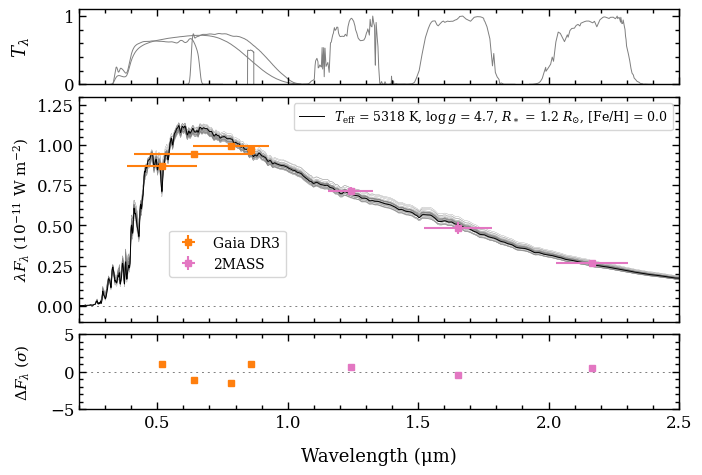

 [DONE]


In [26]:
fig = species.plot_spectrum(boxes=[samples, model_box, object_box],
                            filters=filters,
                            residuals=residuals,
                            plot_kwargs=[{'ls': '-', 'lw': 0.2, 'color': 'gray'},
                                         {'ls': '-', 'lw': 0.7, 'color': 'black'},
                                         {'GAIA/GAIA3.G': {'marker': 's', 'ms': 5., 'color': 'tab:orange', 'ls': 'none', 'label': 'Gaia DR3'},
                                          'GAIA/GAIA3.Gbp': {'marker': 's', 'ms': 5., 'color': 'tab:orange', 'ls': 'none'},
                                          'GAIA/GAIA3.Grp': {'marker': 's', 'ms': 5., 'color': 'tab:orange', 'ls': 'none'},
                                          'GAIA/GAIA3.Grvs': {'marker': 's', 'ms': 5., 'color': 'tab:orange', 'ls': 'none'},
                                          '2MASS/2MASS.J': {'marker': 's', 'ms': 5., 'color': 'tab:pink', 'ls': 'none', 'label': '2MASS'},
                                          '2MASS/2MASS.H': {'marker': 's', 'ms': 5., 'color': 'tab:pink', 'ls': 'none'},
                                          '2MASS/2MASS.Ks': {'marker': 's', 'ms': 5., 'color': 'tab:pink', 'ls': 'none'}}],
                            xlim=(0.2, 2.5),
                            ylim=(-1.e-12, 1.3e-11),
                            ylim_res=(-5., 5.),
                            scale=('linear', 'linear'),
                            offset=(-0.5, -0.08),
                            figsize=(6., 4.),
                            object_type='star',
                            quantity='flux',
                            legend=[{'loc': 'upper right', 'fontsize': 9.},
                                    {'loc': (0.15, 0.2), 'fontsize': 10.}],
                            output=None)

Note that the photometric uncertainties are inflated in the plot by the best-fit parameters that were fitted. These parameters had been applied to the data when running the [update_objectbox](https://species.readthedocs.io/en/latest/species.util.html#species.util.read_util.update_objectbox) on the [ObjectBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ObjectBox).

The [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum) function returned the [Figure](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) object of the plot. The functionalities of [Matplotlib](https://matplotlib.org/stable/index.html) can be used for further customization of the plot. For example, the axes of the plot are stored at the `axes` attribute of `Figure`.

In [27]:
fig.axes

[<Axes: ylabel='$\\lambda$$F_\\lambda$ (10$^{-11}$ W m$^{-2}$)'>,
 <Axes: ylabel='$T_\\lambda$'>,
 <Axes: xlabel='Wavelength (μm)', ylabel='$\\Delta$$F_\\lambda$ ($\\sigma$)'>]

## Photometric calibration

Now that we have the posterior samples of the atmospheric parameters, we can calculated synthetic photometry (including uncertainties) for any other filter. As an example, we will calculate the magnitude and flux for the VLT/ERIS $M'$ filter. The [plot_mag_posterior](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_mcmc.plot_mag_posterior) function plots the distribution of the magnitudes, by propagating the posterior of the atmospheric parameters, and returns an array with the samples. We simply need to specify the database `tag` and provide the `filter_name` name as listed on the [SVO Filter Profile Service](http://svo2.cab.inta-csic.es/svo/theory/fps/)). The function returns an [ndarray](https://numpy.org/doc/stable/reference/arrays.ndarray.html) with the samples and the [Figure](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) of the plot that can be used for further customization.

Adding filter: Paranal/ERIS.Mp... [DONE]


Getting MCMC photometry:   0%|          | 0/9293 [00:00<?, ?it/s]

Plotting photometry samples...

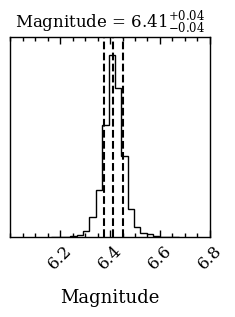

 [DONE]


In [28]:
phot_mag, fig = species.plot_mag_posterior(tag='pztel',
                                           filter_name='Paranal/ERIS.Mp',
                                           xlim=(6.0, 6.8),
                                           output=None)

There is also the [get_mcmc_photometry](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_mcmc_photometry) method of [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database), which works in a similar way as [plot_mag_posterior](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_mcmc.plot_mag_posterior), but can also return the posterior of the flux density instead of the magnitude.

In [29]:
phot_flux = database.get_mcmc_photometry(tag='pztel',
                                         filter_name='Paranal/ERIS.Mp',
                                         phot_type='flux')

Getting MCMC photometry:   0%|          | 0/9293 [00:00<?, ?it/s]

/Users/tomasstolker/applications/species/species/read/read_model.py:799: UserWarning: The '2MASS/2MASS_error' parameter is not required by 'bt-nextgen' so the parameter will be ignored. The mandatory parameters are ['teff', 'logg', 'feh'].
  warnings.warn(
/Users/tomasstolker/applications/species/species/read/read_model.py:799: UserWarning: The 'GAIA/GAIA3_error' parameter is not required by 'bt-nextgen' so the parameter will be ignored. The mandatory parameters are ['teff', 'logg', 'feh'].
  warnings.warn(


To calculate the flux density in the $M'$-band, we simply adopt the mean and the standard deviation of the distribution.

In [30]:
print(f'Flux density (W m-2 um-1) = {np.mean(phot_flux):.2e} +/- {np.std(phot_flux):.2e}')

Flux density (W m-2 um-1) = 5.78e-14 +/- 2.25e-15


## Spectral calibration

We can also compute a stellar, synthetic spectrum with uncertainties for a specific instrument. To do so, we use again the [get_mcmc_spectra](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_mcmc_spectra) method from earlier, but this time we draw a larger number of spectra. Furthermore, for our hypothetical instrument, we assume a resolving power of $R = 100$ and set the wavelength points (20 linearly-spaced points between 1 and 2.5 $\mu$m) as argument of `wavel_resample`.

In [31]:
samples = database.get_mcmc_spectra(tag='pztel',
                                    random=100,
                                    wavel_range=(0.2, 10.),
                                    spec_res=100.,
                                    wavel_resample=np.linspace(1., 2.5, 20))

Getting MCMC spectra:   0%|          | 0/100 [00:00<?, ?it/s]

Next, we calculate the mean and standard deviation of the 100 samples, which we adopt as the synthetic spectrum of PZ Tel.

In [32]:
spec_flux = np.mean([box.flux for box in samples], axis=0)
spec_sigma = np.std([box.flux for box in samples], axis=0)

Let's write the synthetic spectrum to a text file. 

In [33]:
calib_spec = np.column_stack([samples[0].wavelength, spec_flux, spec_sigma])
np.savetxt('calib_spec.dat', calib_spec)

Now we can use the [add_object](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.add_object) method to append the spectrum to the data of PZ Tel in the database. The parallax and magnitudes were already provided previously so we can set the arguments of `parallax` and `app_mag` to `None`.

In [34]:
database.add_object(object_name='PZ Tel',
                    parallax=None,
                    app_mag=None,
                    spectrum={'calibration': ('calib_spec.dat', None, 100.)})

Adding object: PZ Tel
   - Spectrum:
      - Database tag: calibration
      - Filename: calib_spec.dat
      - Data shape: (20, 3)
      - Wavelength range (um): 1.00 - 2.50
      - Mean flux (W m-2 um-1): 3.19e-12
      - Mean error (W m-2 um-1): 1.15e-13
   - Spectral resolution:
      - calibration: 100.0


Next, we use the [get_object](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_object) method for extracting all the data of PZ Tel from the database and storing these in an [ObjectBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ObjectBox). We need to apply again the [update_objectbox](https://species.readthedocs.io/en/latest/species.util.html#species.util.read_util.update_objectbox) function to account for the inflated errors of the 2MASS fluxes.

In [35]:
object_box = database.get_object(object_name='PZ Tel')
object_box = species.update_objectbox(object_box, best_sample)

Getting object: PZ Tel... [DONE]
Inflating the uncertainty of 2MASS/2MASS.H by a factor 1.41 to 1.87e-13 (W m-2 um-1)... [DONE]
Inflating the uncertainty of 2MASS/2MASS.J by a factor 1.41 to 1.57e-13 (W m-2 um-1)... [DONE]
Inflating the uncertainty of 2MASS/2MASS.Ks by a factor 1.41 to 3.84e-14 (W m-2 um-1)... [DONE]
Inflating the uncertainty of GAIA/GAIA3.G by a factor 2.49 to 1.07e-13 (W m-2 um-1)... [DONE]
Inflating the uncertainty of GAIA/GAIA3.Gbp by a factor 2.49 to 2.29e-13 (W m-2 um-1)... [DONE]
Inflating the uncertainty of GAIA/GAIA3.Grp by a factor 2.49 to 1.62e-13 (W m-2 um-1)... [DONE]
Inflating the uncertainty of GAIA/GAIA3.Grvs by a factor 2.49 to 2.48e-13 (W m-2 um-1)... [DONE]


If we now open the [ObjectBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ObjectBox) with [open_box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box.open_box) then we see that the synthetic spectrum is indeed included together with the previously added data.

In [36]:
object_box.open_box()

Opening ObjectBox...
name = PZ Tel
filters = ['2MASS/2MASS.H', '2MASS/2MASS.J', '2MASS/2MASS.Ks', 'GAIA/GAIA3.G', 'GAIA/GAIA3.Gbp', 'GAIA/GAIA3.Grp', 'GAIA/GAIA3.Grvs']
mean_wavel = {'2MASS/2MASS.H': 1.6513664598414621, '2MASS/2MASS.J': 1.24105170694321, '2MASS/2MASS.Ks': 2.1656311232670684, 'GAIA/GAIA3.G': 0.6390220344836051, 'GAIA/GAIA3.Gbp': 0.5182576434561539, 'GAIA/GAIA3.Grp': 0.7825078823058362, 'GAIA/GAIA3.Grvs': 0.8579038886678563}
magnitude = {'2MASS/2MASS.H': array([6.48600006, 0.049     ]), '2MASS/2MASS.J': array([6.85599995, 0.021     ]), '2MASS/2MASS.Ks': array([6.36600018, 0.024     ]), 'GAIA/GAIA3.G': array([8.10165977e+00, 3.16641662e-03]), 'GAIA/GAIA3.Gbp': array([8.49609852e+00, 5.96450345e-03]), 'GAIA/GAIA3.Grp': array([7.52674723e+00, 5.56069163e-03]), 'GAIA/GAIA3.Grvs': array([7.28863096, 0.00959738])}
flux = {'2MASS/2MASS.H': array([2.92837677e-12, 2.28863443e-13]), '2MASS/2MASS.J': array([5.74224978e-12, 1.92280142e-13]), '2MASS/2MASS.Ks': array([1.22822262e-12, 

Let's have a look at the content of the returned [ObjectBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ObjectBox) by simply passing it to the [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum) function!

Plotting spectrum...

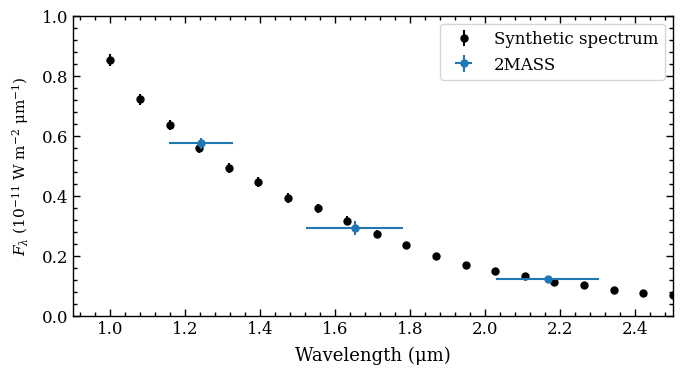

 [DONE]


In [37]:
fig = species.plot_spectrum(boxes=[object_box],
                            plot_kwargs=[{'calibration': {'marker': 'o', 'ms': 5., 'color': 'black', 'ls': 'none', 'label': 'Synthetic spectrum'},
                                          '2MASS/2MASS.J': {'marker': 'o', 'ms': 5., 'color': 'tab:blue', 'ls': 'none', 'label': '2MASS'},
                                          '2MASS/2MASS.H': {'marker': 'o', 'ms': 5., 'color': 'tab:blue', 'ls': 'none'},
                                          '2MASS/2MASS.Ks': {'marker': 'o', 'ms': 5., 'color': 'tab:blue', 'ls': 'none'}}],
                            xlim=(0.9, 2.5),
                            ylim=(0., 1e-11),
                            scale=('linear', 'linear'),
                            offset=(-0.1, -0.07),
                            figsize=(6., 3.),
                            legend={'loc': 'upper right', 'fontsize': 12.},
                            output=None)

The [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum) function returned the [Figure](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) object of the plot. The functionalities of [Matplotlib](https://matplotlib.org/stable/index.html) can be used for further customization of the plot. For example, the axes of the plot are stored at the `axes` attribute of `Figure`.

In [38]:
fig.axes

[<Axes: xlabel='Wavelength (μm)', ylabel='$F_\\lambda$ (10$^{-11}$ W m$^{-2}$ μm$^{-1}$)'>]